In [47]:
import pandas as pd
from pathlib import Path
import numpy as np

MAX_CURRENT = 135  # A

DATA_DIR = Path("/mnt/RDS/projects/ultracoldsr-aion/live/labbook/2023-04-04-ch2-coils-inductance")
DATA_TURN_ON = DATA_DIR / "turnon.csv"
DATA_TURN_OFF = DATA_DIR / "turnoff.csv"

In [48]:
data_turnon = pd.read_csv(DATA_TURN_ON).set_index("in s")
data_turnoff = pd.read_csv(DATA_TURN_OFF).set_index("in s")

In [49]:
data_turnon = data_turnon.rename(columns={
"C1 in V":"trigger",
"C2 in V":"current",
"C3 in V":"coil_bottom",
"C4 in V":"coil_top",

})
data_turnoff = data_turnoff.rename(columns={
"C1 in V":"trigger",
"C2 in V":"current",
"C3 in V":"coil_bottom",
"C4 in V":"coil_top",

})
data_turnoff["coil"] = data_turnoff["coil_top"] - data_turnoff["coil_bottom"]
data_turnon["coil"] = data_turnon["coil_top"] - data_turnon["coil_bottom"]

data_turnon.drop(["coil_bottom", "coil_top"],axis=1, inplace=True)
data_turnoff.drop(["coil_bottom", "coil_top"],axis=1, inplace=True)

<AxesSubplot:xlabel='in s'>

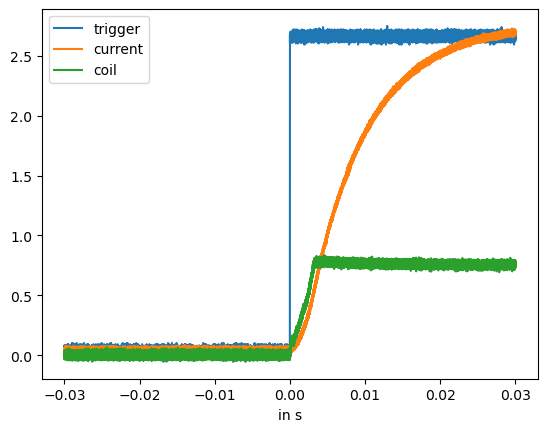

In [50]:
data_turnon.plot()

<AxesSubplot:xlabel='in s'>

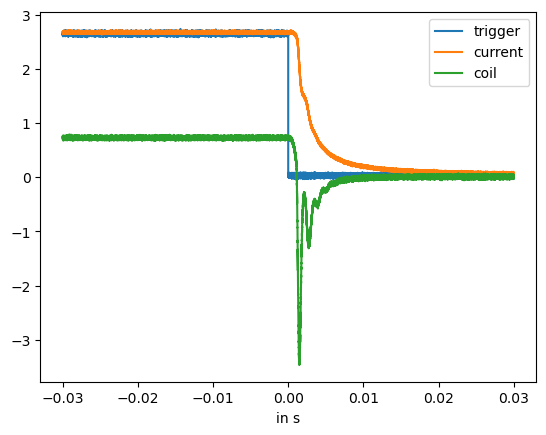

In [51]:
data_turnoff.plot()

$$
V_\text{coil} = L \frac{d}{dt} I + R I
$$

At $t<0$, $\frac{d}{dt} I=0$ so $R = V_\text{coil}/I$

But first, get the scaling factor using I_MAX = 135A

In [52]:
V_current_max = data_turnoff.loc[:0, 'current'].mean()
ammeter_sensivitiy = MAX_CURRENT / V_current_max

In [53]:
smoothing_window = 500

I = data_turnoff['current'].ewm(span = smoothing_window).mean() * ammeter_sensivitiy
V = data_turnoff['coil'].ewm(span = smoothing_window).mean()

<AxesSubplot:xlabel='in s'>

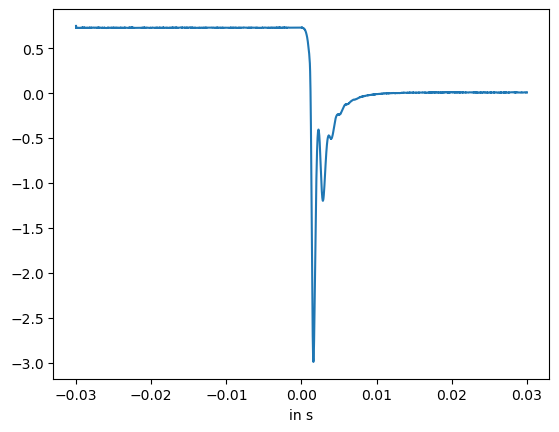

In [54]:
V.plot()

<AxesSubplot:xlabel='in s'>

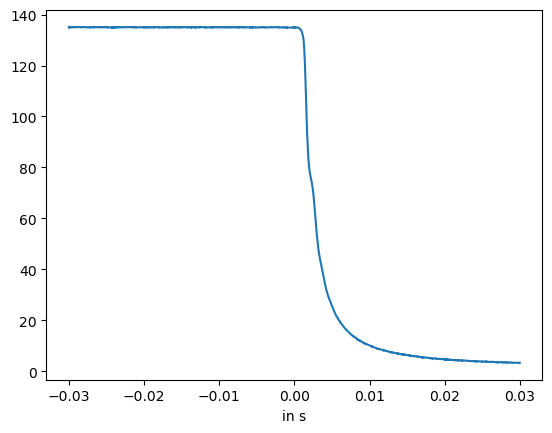

In [55]:
I.plot()

In [56]:
R = V / I
R=R.loc[:0].mean()
R

0.005392354784035159

<AxesSubplot:xlabel='in s'>

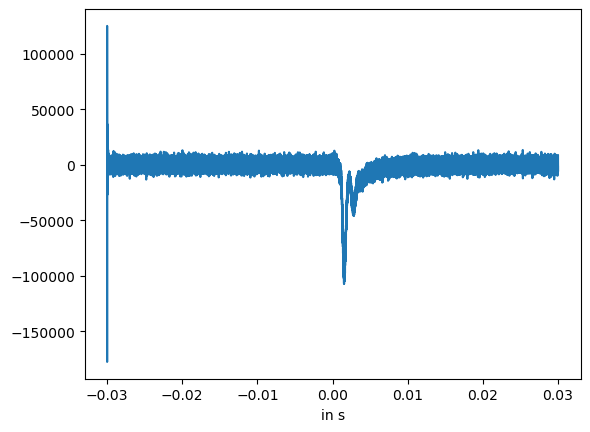

In [57]:
dIdt = pd.Series(np.gradient(I, I.index.to_series()), index=I.index)
dIdt.plot()

array([3.55619151e-05])

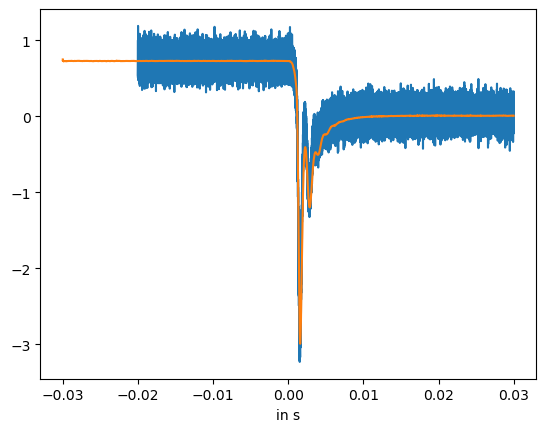

In [58]:
L0 = 1e-6
t_start = -0.02

from scipy.optimize import curve_fit

def fit_func(I, L):
    dIdt = pd.Series(np.gradient(I, I.index.to_series()), index=I.index)
    return L * dIdt + R * I

L_fit_off, _ = curve_fit(fit_func, I.loc[-0.02:], V.loc[-0.02:], p0=L0)

V_sim = fit_func(I.loc[-0.02:], L_fit_off)

V_sim.plot()
V.plot()

L_fit_off

So we conclude with this cludgy method that L = 35.6 uH. Let's also try the turn on data

array([3.55619151e-05])

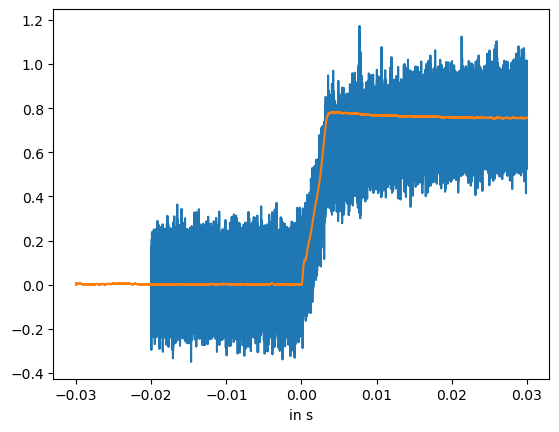

In [59]:
I = data_turnon['current'].ewm(span = smoothing_window).mean() * ammeter_sensivitiy
V = data_turnon['coil'].ewm(span = smoothing_window).mean()

L0 = 1e-6
t_start = -0.02

from scipy.optimize import curve_fit

def fit_func(I, L):
    dIdt = pd.Series(np.gradient(I, I.index.to_series()), index=I.index)
    return L * dIdt + R * I

L_fit_on, _ = curve_fit(fit_func, I.loc[-0.02:], V.loc[-0.02:], p0=L0)

V_sim = fit_func(I.loc[-0.02:], L_fit_on)

V_sim.plot()
V.plot()

L_fit_off

From the turn-on data we get L = 28.6 uH. Neither are great fits, but both are > 1uH. 

This isn't super important, but let's go for L = 

In [60]:
L_fit = (L_fit_off + L_fit_on) / 2

array([3.20967719e-05])

In [62]:
L_std = np.sqrt((L_fit_off - L_fit)**2+(L_fit_on - L_fit)**2)
L_std

array([6.9302864e-06])